In [8]:
import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/sr-press


In [9]:
from socceraction.data.statsbomb import StatsBombLoader
from statsbombpy import sb
from express.databases import SQLiteDatabase
from express.visualization import plot_action
from express.utils import add_names

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
SBL = StatsBombLoader(root=os.path.join(base_path, "open-data/data"), getter="local")
competition = sb.competitions()

# HTTPError: 404 Client Error: Not Found for ur
Error_competition = [(11, 90), (7, 235), (7, 108), (44, 107)] # La-Liga 20/21, Ligue1 21/22, Ligue1 22/23 
competition = competition[~competition[["competition_id", "season_id"]].apply(tuple, axis=1).isin(Error_competition)] # HTTPError: 404 Client Error: Not Found for ur
competition = competition[(competition["match_available_360"].notna()) & (competition["competition_gender"] == "male")]
competition

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
29,43,106,International,FIFA World Cup,male,False,True,2022,2024-05-15T10:23:32.854925,2024-06-11T11:30:50.462448,2024-06-11T11:30:50.462448,2024-05-15T10:23:32.854925
68,55,282,Europe,UEFA Euro,male,False,True,2024,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,2024-07-15T15:52:24.778809,2024-07-15T15:48:50.315500
69,55,43,Europe,UEFA Euro,male,False,True,2020,2024-04-16T12:44:40.558402,2024-04-16T12:47:18.505110,2024-04-16T12:47:18.505110,2024-04-16T12:44:40.558402


In [12]:
train_competition = competition[~(competition["competition_name"] == "FIFA World Cup")]
test_competition = competition[(competition["competition_name"] == "FIFA World Cup")]

print(train_competition.shape, test_competition.shape)

(3, 12) (1, 12)


In [13]:
train_games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in train_competition.itertuples()
]).reset_index(drop=True)

test_games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in test_competition.itertuples()
]).reset_index(drop=True)

print(train_games.shape, test_games.shape)
train_games

(136, 12) (64, 12)


,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3895302,281,9,Regular Season,29,2024-04-14 17:30:00,904,176,5,0,BayArena,Harm Osmers
1,3895292,281,9,Regular Season,28,2024-04-06 15:30:00,190,904,0,1,Stadion An der Alten Försterei,Benjamin Brand
2,3895333,281,9,Regular Season,32,2024-05-05 18:30:00,184,904,1,5,Deutsche Bank Park,Christian Dingert
3,3895340,281,9,Regular Season,33,2024-05-12 20:30:00,868,904,0,5,Vonovia Ruhrstadion,Benjamin Brand
4,3895348,281,9,Regular Season,34,2024-05-18 16:30:00,904,172,2,1,BayArena,Matthias Jöllenbeck
...,...,...,...,...,...,...,...,...,...,...,...,...
131,3788742,43,55,Group Stage,1,2021-06-12 18:00:00,776,1835,0,1,Parken,Anthony Taylor
132,3788775,43,55,Group Stage,3,2021-06-23 18:00:00,908,772,0,5,Estadio de La Cartuja,Björn Kuipers
133,3788776,43,55,Group Stage,3,2021-06-23 18:00:00,790,789,3,2,Saint-Petersburg Stadium,Michael Oliver
134,3788743,43,55,Group Stage,1,2021-06-12 21:00:00,782,796,3,0,Saint-Petersburg Stadium,Antonio Miguel Mateu Lahoz


In [14]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f2af2f19940>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f2af2f199a0>


In [15]:
for _, game in tqdm(train_games.iterrows(), desc="train_game loading"):
    dataset = {"getter": "remote", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"]}
    
    train_db.import_data(**dataset)

for _, game in tqdm(test_games.iterrows(), desc="test_game loading"):
    dataset = {"getter": "remote", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"]}
    
    test_db.import_data(**dataset)

train_game loading: 0it [00:00, ?it/s]

test_game loading: 0it [00:00, ?it/s]

In [16]:
train_db.games()

,season_id,competition_id,game_day,game_date,home_team_id,away_team_id,competition_stage,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
3788741,43,55,1,2021-06-11 21:00:00,909,914,Group Stage,0,3,Estadio Olímpico,Danny Desmond Makkelie
3788742,43,55,1,2021-06-12 18:00:00,776,1835,Group Stage,0,1,Parken,Anthony Taylor
3788743,43,55,1,2021-06-12 21:00:00,782,796,Group Stage,3,0,Saint-Petersburg Stadium,Antonio Miguel Mateu Lahoz
3788744,43,55,1,2021-06-12 15:00:00,907,773,Group Stage,1,1,Bakı Olimpiya Stadionu,Clément Turpin
3788745,43,55,1,2021-06-13 15:00:00,768,785,Group Stage,1,0,Wembley Stadium,Daniele Orsato
...,...,...,...,...,...,...,...,...,...,...,...
3942349,282,55,5,2024-07-05 22:00:00,780,771,Quarter-finals,0,0,Volksparkstadion,Michael Oliver
3942382,282,55,5,2024-07-06 22:00:00,941,909,Quarter-finals,2,1,Olympiastadion Berlin,Clément Turpin
3942752,282,55,6,2024-07-09 22:00:00,772,771,Semi-finals,2,1,Allianz Arena,Slavko Vinčić


In [17]:
game_id = 3895302

df_actions = add_names(train_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3895302,0,221b0c8d-6386-4ae8-bb4a-a1dc98742312,1,3.417,176,34870,52.0625,33.660,53.8125,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 12299, 'name': '...",None,0,None,pass,success,foot_right
1,3895302,1,77809242-1460-4395-8779-94a0cfc275b1,1,3.870,176,12299,53.8125,34.340,53.8125,...,176.0,From Kick Off,0,"{'carry': {'end_location': [59.0, 40.6]}}",None,0,None,dribble,success,foot
2,3895302,2,ff56e821-21e9-4cef-ba2a-7eb5eb3769c6,1,4.732,176,12299,53.8125,34.085,74.7250,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 31100, 'name': '...","[[90.44126933110154, 68.0], [67.695055809645, ...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
3,3895302,3,cf9088bc-7e59-4d57-8ac5-31658da858bb,1,6.728,176,31100,74.7250,36.295,74.7250,...,176.0,From Kick Off,0,"{'carry': {'end_location': [35.1, 43.7]}}","[[94.70003623525969, 68.0], [70.82236198763701...",1,"[{'teammate': True, 'actor': True, 'keeper': F...",dribble,success,foot
4,3895302,4,4464cb75-f45f-4508-8444-2560d1625d06,1,7.622,176,31100,74.7250,36.720,76.3875,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 51769, 'name': '...","[[96.23592025888192, 68.0], [71.95638033011264...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right


In [28]:
df_actions["freeze_frame_360"].iloc[-2]

13

In [29]:
df = df_actions[(df_actions["type_name"] == "pressing") & (df_actions["freeze_frame_360"].notna())]
df

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
6,3895302,6,cfa1f5e1-4e8e-4fc2-bbc8-4df5fdef8283,1,9.637,904,33401,74.3750,55.335,74.3750,...,176.0,From Kick Off,0,{},"[[55.066665754930455, 23.91276629088182], [55....",1,"[{'teammate': False, 'actor': False, 'keeper':...",pressing,fail,foot
11,3895302,11,a43fa179-91f5-4b22-9f74-7f20af0570e4,1,12.832,904,30606,48.2125,55.845,48.2125,...,176.0,From Kick Off,0,{},"[[49.163592429021435, 27.793803667302768], [43...",1,"[{'teammate': True, 'actor': True, 'keeper': F...",pressing,fail,foot
17,3895302,17,533ffee0-b9fc-4065-a9db-cb729523d926,1,15.552,904,8221,44.1875,54.995,44.1875,...,176.0,From Kick Off,0,{},"[[43.36676102543239, 24.81271918222688], [32.0...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
20,3895302,20,c615b3b6-58de-4f77-8190-f0d7f80bbcff,1,16.383,904,9195,50.0500,51.000,50.0500,...,176.0,From Kick Off,0,{},"[[40.910829695169525, 20.64312315056911], [27....",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
42,3895302,42,9c1c3a13-867e-45a0-ac1d-4bd53c758e26,1,49.616,176,8826,52.1500,50.915,52.1500,...,904.0,Regular Play,0,{},"[[81.40211633400031, 68.0], [65.45307831258052...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010,3895302,3010,e8a3f722-0ea4-4c66-a1fe-b6bb58903d9c,2,2635.170,176,52124,58.2750,5.100,58.2750,...,904.0,From Keeper,0,{},"[[63.52152821055386, 46.12911961031962], [80.3...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
3018,3895302,3018,a4b0bb5c-cc11-45b7-8e69-517b89c6bcc6,2,2652.619,904,28268,18.4625,50.150,18.4625,...,176.0,Regular Play,0,{},"[[0.0, 0.0], [0.0, 48.41363281770536], [15.253...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
3021,3895302,3021,4ef92e5a-44e5-4ff4-b457-3c52d96d546e,2,2653.918,904,10336,19.0750,47.600,19.0750,...,176.0,Regular Play,0,{},"[[0.0, 0.0], [0.0, 46.68727699949346], [16.498...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
3024,3895302,3024,f908d853-a3e9-4ad7-99b4-6aef1f3e3286,2,2660.647,176,12299,55.1250,44.795,55.1250,...,904.0,From Counter,0,{},"[[69.96011217490444, 60.1561831423604], [102.6...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,success,foot


In [36]:
df[(df["freeze_frame_360"].apply(lambda x : len(x)<=7))]

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
1916,3895302,1916,8204cd62-9685-468f-815a-2784a58f1df2,2,466.542,904,40724,98.875,45.815,98.875,...,176.0,Regular Play,0,{},"[[93.83521281961538, 0.0], [70.42565886559555,...",1,"[{'teammate': False, 'actor': False, 'keeper':...",pressing,success,foot


<Axes: title={'center': 'pressing'}>

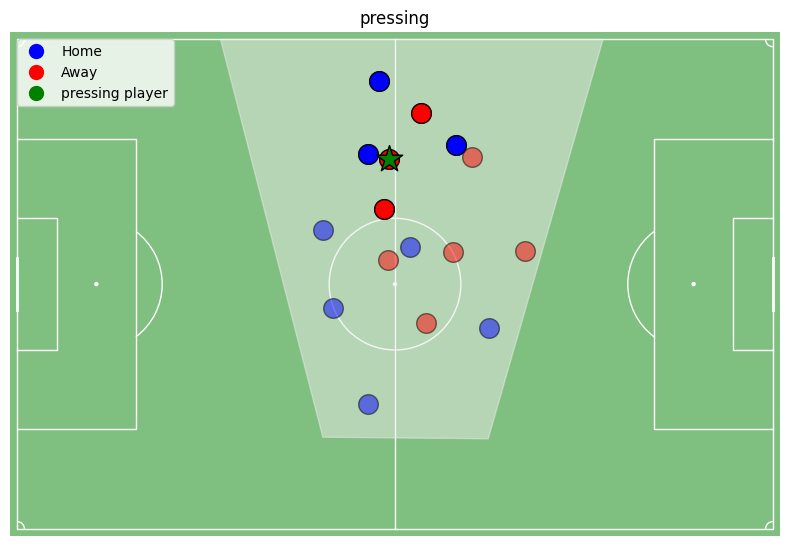

In [21]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3895302)

plot_action(df_actions.loc[pressure_idx], home_team_id=home_team_id)

Skip action due to missing freeze frame


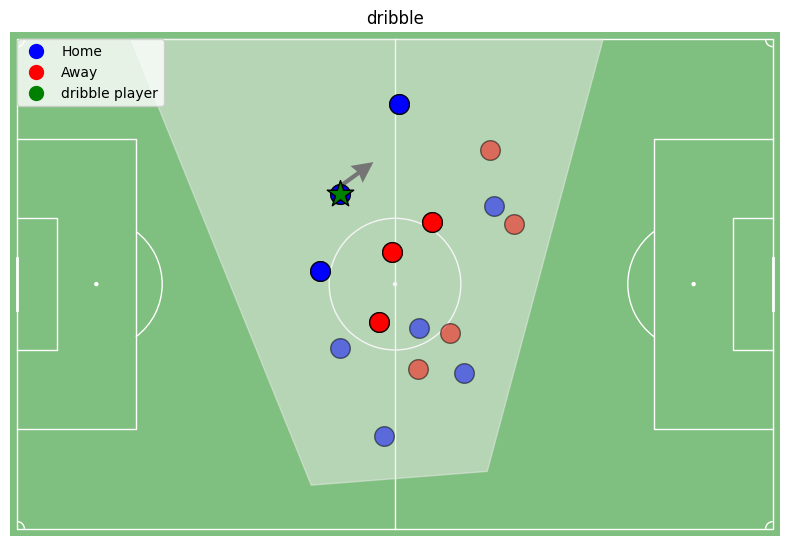

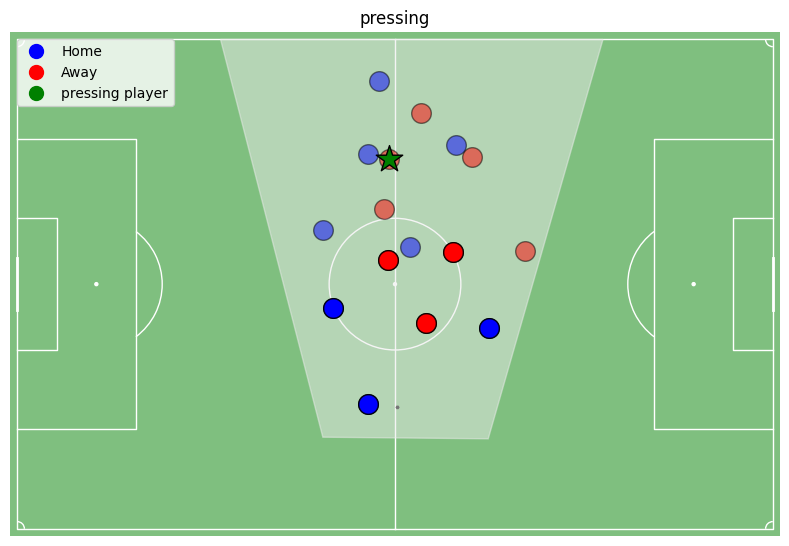

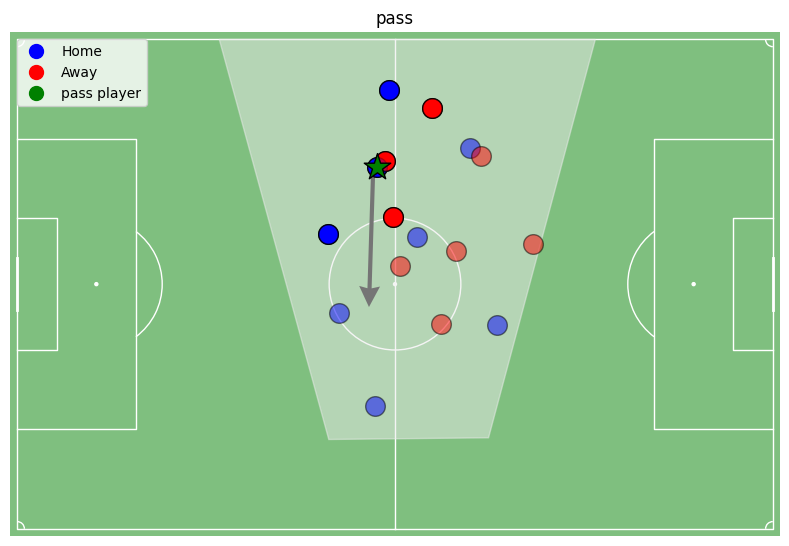

In [ ]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3895302)

for idx in range(pressure_idx-2, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame")
        continue
    plot_action(df_actions.loc[idx], home_team_id=home_team_id)